In [39]:
#!apt-get install git
#!pip install opencv-python

## Original Notebook classifying all 4 classes:
- 0 : Glioma Tumor
- 1 : Meningioma Tumor
- 2 : No Tumor
- 3 : Pituitary Tumor

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
import random
import mlflow
import my_functions
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical

from my_functions import DataLoader
from my_functions import Data_Augmentation

2024-08-26 17:21:29.988250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
# from google.colab import drive


### Data Source: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [3]:
training_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Training'
testing_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Testing'

In [4]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

''

We can see from the above output that Tensorflow is utilising the NVIDIA Tesla T4 GPU.

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Checking to see the different folders within our path
for image_class in os.listdir(training_path):
  print(image_class)


no_tumor
meningioma_tumor
glioma_tumor
pituitary_tumor


In [6]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

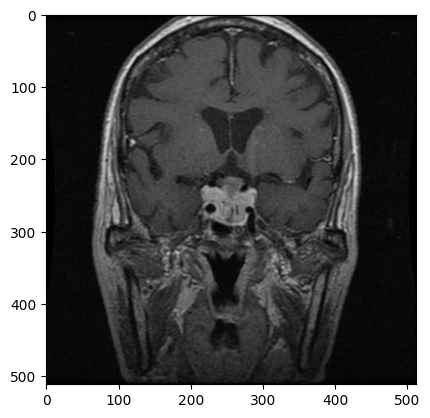

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [50]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']
# for image_class in os.listdir(training_path):
#   for image in os.listdir(os.path.join(training_path, image_class)):
#     image_path = os.path.join(training_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

In [51]:
# for image_class in os.listdir(testing_path):
#   for image in os.listdir(os.path.join(testing_path, image_class)):
#     image_path = os.path.join(testing_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

The above code can be used to verify the extention of images, and filter out those with inapropriate extentions. In this dataset the images were all .jpg format, and thus the code did not need to be utilised

# Loading data

The datset was already split into testing and training data so we do not need to define these later

In [9]:
#Initialise class
data_loader = DataLoader()

# Load the training dataset
Training_data = data_loader.Load_Training_data(training_path)
# Load the validation dataset
Validation_data = data_loader.Load_Validaion_data(training_path)
# Load the testing dataset
Testing_data = data_loader.Load_Testing_data(testing_path)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [10]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()
batch_training = Training_iterator.next()


In [11]:
batch_training[0].shape # Images are now of dimension 256 x 256

(32, 256, 256, 3)

In [12]:
batch_training[1] # Labels are 0,1,2 and 3 for the different classes

array([3, 0, 2, 0, 2, 2, 3, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 2, 1,
       0, 1, 2, 3, 3, 3, 0, 3, 1, 2], dtype=int32)

In [13]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


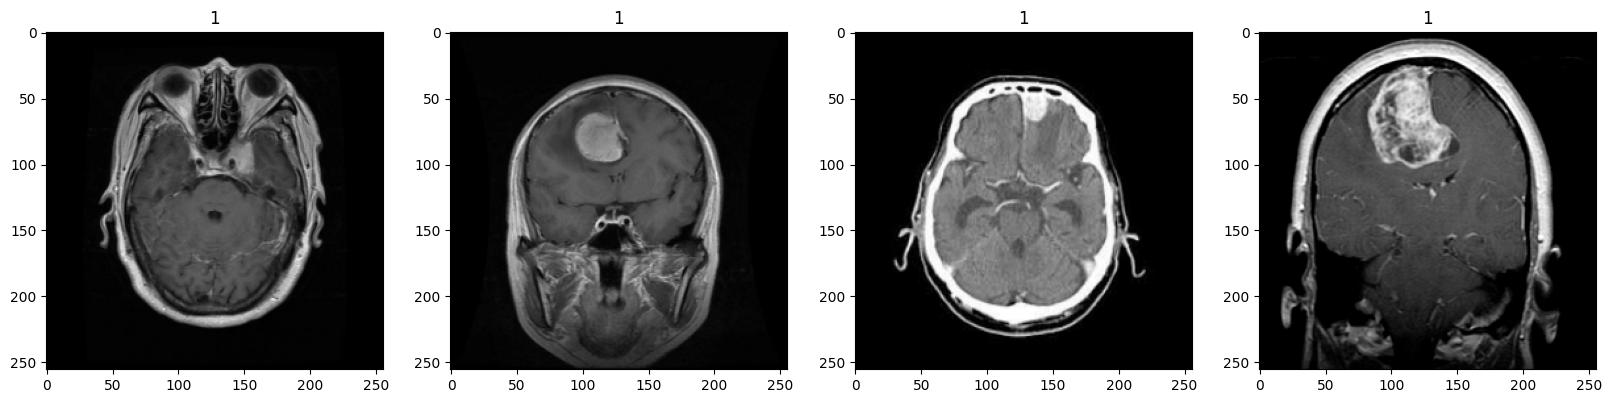

In [14]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


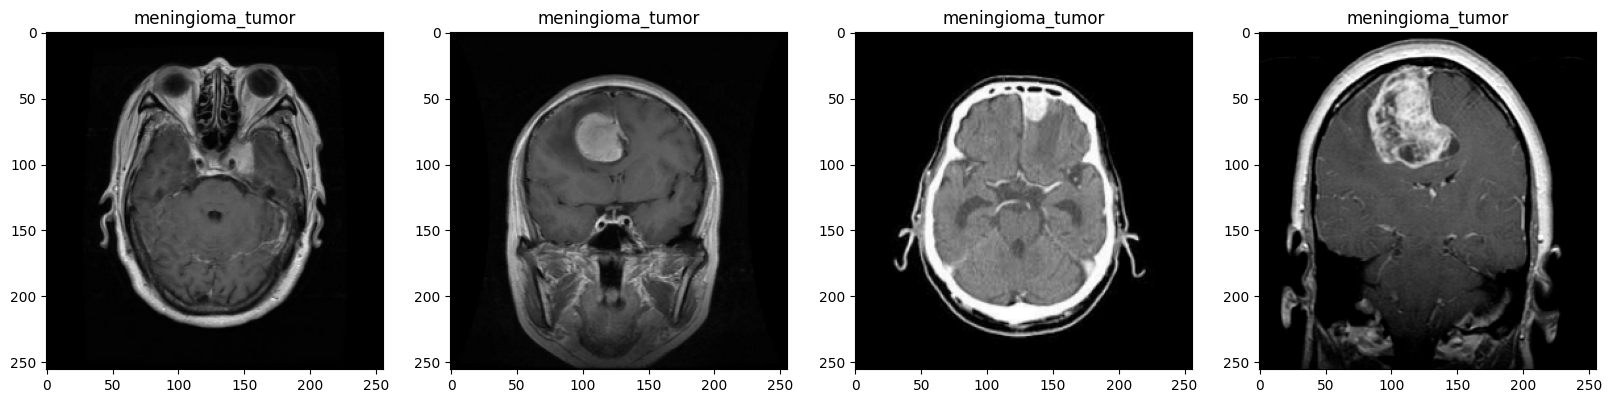

In [15]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(class_names[batch_training[1][img_index]])

# Preprocessing Data

In [59]:

# Training_data = my_functions.preprocess_data(Training_data, my_functions.augment_image)
# Validation_data = my_functions.preprocess_data(Validation_data, my_functions.augment_image)
# Testing_data = my_functions.preprocess_data(Testing_data, my_functions.augment_image)


In [16]:
Augmentator = Data_Augmentation()

num_classes = 4

# Load the training dataset
Training_data = Training_data.map(Augmentator.augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the validation dataset
Validation_data = Validation_data.map(Augmentator.augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
#Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


In [17]:
Training_data.as_numpy_iterator().next()[0]

array([[[[0.09915747, 0.09915747, 0.09915747],
         [0.09417677, 0.09417677, 0.09417677],
         [0.09704351, 0.09704351, 0.09704351],
         ...,
         [0.09833027, 0.09833027, 0.09833027],
         [0.09499297, 0.09499297, 0.09499297],
         [0.09909549, 0.09909549, 0.09909549]],

        [[0.14117648, 0.14117648, 0.14117648],
         [0.14117648, 0.14117648, 0.14117648],
         [0.14509805, 0.14509805, 0.14509805],
         ...,
         [0.14382659, 0.14382659, 0.14382659],
         [0.14662105, 0.14662105, 0.14662105],
         [0.13512346, 0.13512346, 0.13512346]],

        [[0.13549685, 0.13549685, 0.13549685],
         [0.13236827, 0.13236827, 0.13236827],
         [0.13742341, 0.13742341, 0.13742341],
         ...,
         [0.13971594, 0.13971594, 0.13971594],
         [0.14007352, 0.14007352, 0.14007352],
         [0.13756128, 0.13756128, 0.13756128]],

        ...,

        [[0.12941177, 0.12941177, 0.12941177],
         [0.12535232, 0.12535232, 0.12535232]

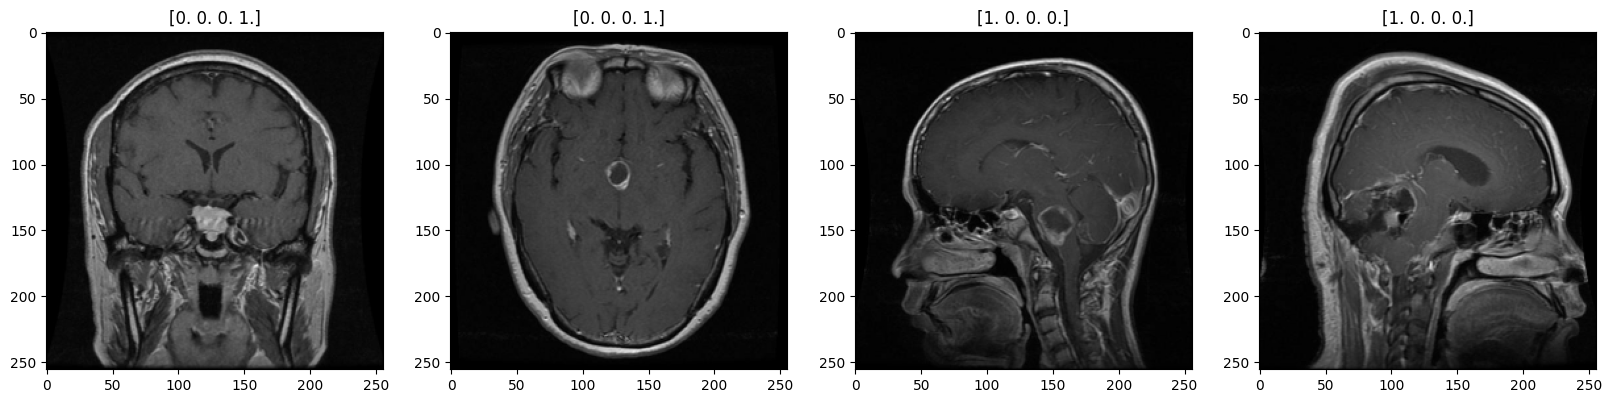

In [18]:
batch_training = Training_data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


# Deep Model

In [63]:
model = Sequential()

l2_1 = l2(0.002)
l2_2 = l2(0.002)
l2_3 = l2(0.002)
# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(64, activation = 'relu', kernel_regularizer = l2_1))
model.add(Dropout(rate =0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer = l2_2))
model.add(Dropout(rate=0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer = l2_3))
model.add(Dropout(rate=0.1))


# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))

/Users/harjitgakhal/.local/share/virtualenvs/Brain-Tumour-Classification-Lpua87O-/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [64]:
mlflow.log_param("l2_1", l2_1)
mlflow.log_param("l2_2", l2_2)
mlflow.log_param("l2_3", l2_3)

MlflowException: Changing param values is not allowed. Param with key='l2_1' was already logged with value='<keras.src.regularizers.regularizers.L2 object at 0x143da0280>' for run ID='2d1a8d10fcd34af3ac7fad78dbff8dfd'. Attempted logging new value '<keras.src.regularizers.regularizers.L2 object at 0x1440c83a0>'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,816,580 (14.56 MB)

 Trainable params: 3,816,580 (14.56 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
logdir = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Notebooks/logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
hist = model.fit(Training_data, epochs = 30, validation_data = Validation_data, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/30


72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4226 - loss: 2.0294 - val_accuracy: 0.5523 - val_loss: 1.4222
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5768 - loss: 1.3392 - val_accuracy: 0.6446 - val_loss: 1.1859
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6178 - loss: 1.1694 - val_accuracy: 0.6185 - val_loss: 1.0773
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6624 - loss: 1.0852 - val_accuracy: 0.6620 - val_loss: 1.0200
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7012 - loss: 0.9553 - val_accuracy: 0.7648 - val_loss: 0.7882
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7701 - loss: 0.8182 - val_accuracy: 0.7718 - val_loss: 0.8169
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8267 - loss: 0.7229 - val_accuracy: 0.7892 - val_loss: 0.7655
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8051 - loss: 0.7250 - val_accuracy: 0.8502 - val_loss: 0.

## Model Evaluation

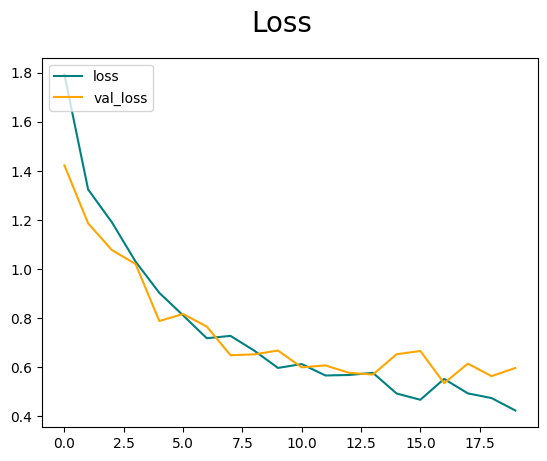

In [ ]:
my_functions.plot_loss(hist)

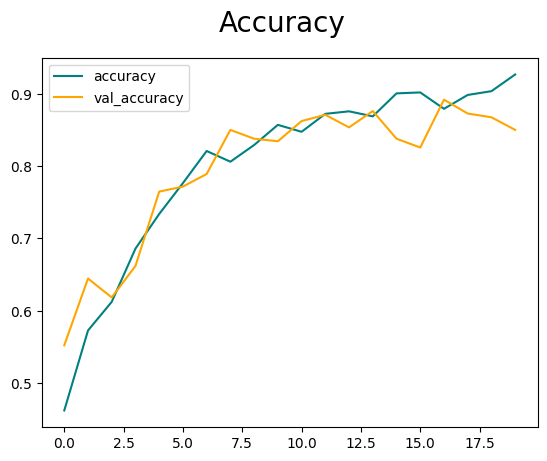

In [ ]:
my_functions.plot_accuracy(hist)

## Testing data

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
labels_testing = []
X_test =[]

for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch
    y_test = [np.where(row == 1)[0][0].tolist() for row in y_test] # Gets the position of the 1 to determine the type of tumor and assigns to a list
    labels_testing.extend(y_test)
    X_test.extend(x_test)

labels_testing = np.array(labels_testing) # Full y_test labels transformed
X_test = np.array(X_test) # Full X_test data

2024-08-20 12:55:32.288686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
y_ = labels_testing # Our true y values
yhat_ =[] # Empty list for predicted variables

yhat = model.predict(X_test)
yhat_binary = np.argmax(yhat, axis=1) # gets value of 1 and position
yhat_.append(yhat_binary)

pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.7732240557670593
Recall: 0.9625850319862366
Accuracy: 0.32487308979034424


### Confusion Matrix

In [ ]:
my_functions.confusion_matrix(y_, yhat_binary)

RecursionError: maximum recursion depth exceeded

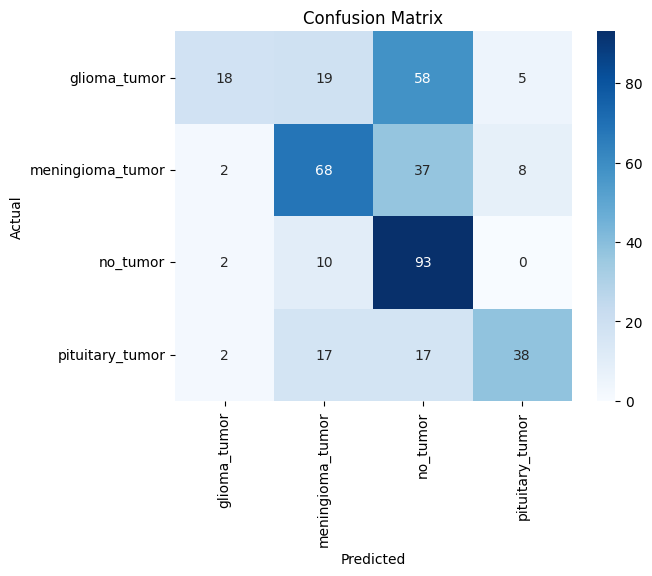

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can say that while Meningioma, Pituitary, and No tumor are being picked up well, Glioma tumor however isn't so easily and is something that would require future work

## Saving model

In [ ]:
model.save('/content/drive/MyDrive/projects/Brain_Tumor_Classification/model')